In [65]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os
from skimage.io import imread
from skimage.color import rgb2gray

In [66]:
# Define class names in the data folder
categories = ['kitchen', 'store', 'bedroom', 'livingroom', 'house', 'industrial', 'stadium', 
              'underwater', 'tallbuilding', 'street', 'highway', 'field', 'coast', 'mountain', 'forest']


In [67]:
# Read train and test images class name and file names
training_images = []
training_labels = []
for category in categories:
    path = 'data/train/' + category + '/'
    for file in os.listdir(path):
        img = cv2.imread(path + file, cv2.IMREAD_GRAYSCALE)
        training_images.append(img)
        training_labels.append(categories.index(category))

In [68]:
test_images = []
test_labels = []
for category in categories:
    path = 'data/test/' + category + '/'
    for file in os.listdir(path):
        img = cv2.imread(path + file, cv2.IMREAD_GRAYSCALE)
        test_images.append(img)
        test_labels.append(categories.index(category))

In [69]:
# Bag of sift feature size
vocab_size = 750

feats = np.empty((0, 128))

In [70]:
for img in training_images:
    kp, des = cv2.SIFT_create().detectAndCompute(img, None)
    feats = np.vstack((feats, des))

In [71]:
# Cluster features into vocab_size clusters
kmeans = KMeans(n_clusters=vocab_size).fit(feats)
vocab = kmeans.cluster_centers_

c:\Users\natha.NSLEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [72]:
train_image_feats = np.zeros((len(training_images), vocab_size))
train_labels = np.array(training_labels)
for i, img in enumerate(training_images):
    kp, des = cv2.SIFT_create().detectAndCompute(img, None)
    D = np.linalg.norm(des[:, None] - vocab[None, :], axis=2)
    b = np.argmin(D, axis=1)
    h, _ = np.histogram(b, bins=np.arange(vocab_size+1))
    train_image_feats[i] = h / np.sum(h)

In [73]:
test_image_feats = np.zeros((len(test_images), vocab_size))
test_labels = np.array(test_labels)
for i, img in enumerate(test_images):
    kp, des = cv2.SIFT_create().detectAndCompute(img, None)
    D = np.linalg.norm(des[:, None] - vocab[None, :], axis=2)
    b = np.argmin(D, axis=1)
    h, _ = np.histogram(b, bins=np.arange(vocab_size+1))
    test_image_feats[i] = h / np.sum(h)

In [74]:
# SVM classifier
svm = SVC(kernel='rbf', C=10, cache_size=10000)
svm.fit(train_image_feats, train_labels)
predicted_labels = svm.predict(test_image_feats)

In [75]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)


In [76]:
print('Accuracy: ', accuracy)

Accuracy:  0.488


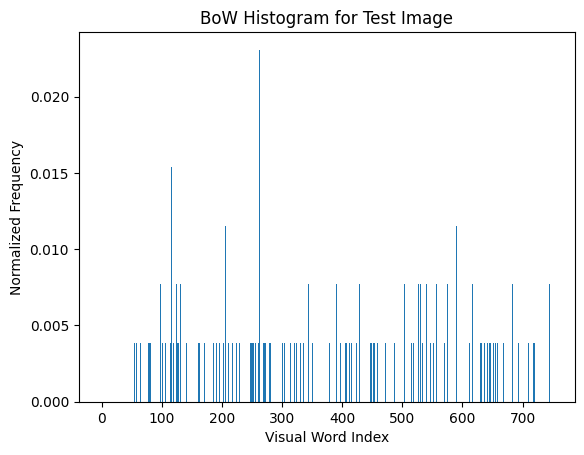

In [77]:
# Display histogram of a test image
test_img_index = 0  # Change this to view histogram for different test images
test_img_feats = test_image_feats[test_img_index]
plt.figure()
plt.bar(range(len(test_img_feats)), test_img_feats)
plt.xlabel('Visual Word Index')
plt.ylabel('Normalized Frequency')
plt.title('BoW Histogram for Test Image')
plt.show()

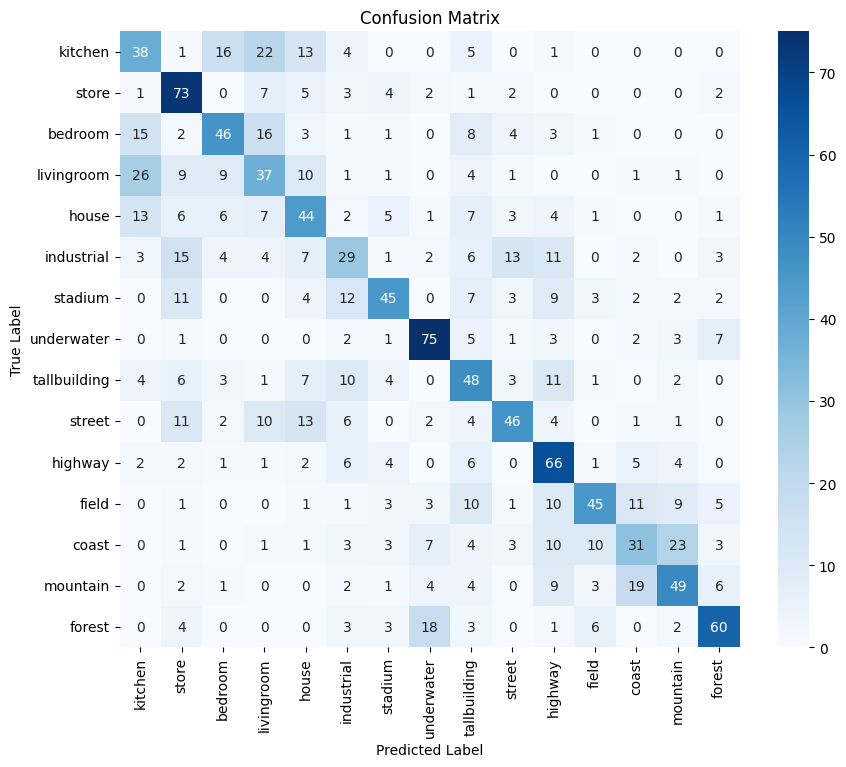

In [78]:
# Plot confusion matrix with labels using Seaborn
import seaborn as sns
# Confusion matrix
cmat = confusion_matrix(test_labels, predicted_labels)


# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# ROC curve
n_classes = len(categories)
targets = label_binarize(test_labels, classes=np.arange(n_classes))
scores = svm.decision_function(test_image_feats)

In [15]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

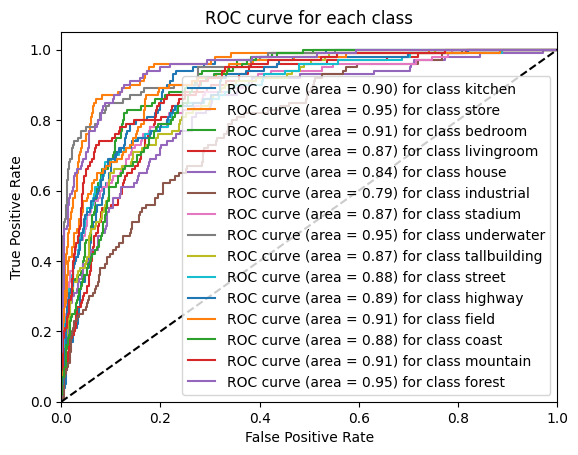

In [16]:
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {categories[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each class')
plt.legend(loc="lower right")
plt.show()

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import load_files
from skimage.feature import hog

In [2]:
# Load train and test data
train_data = load_files('data/train')
test_data = load_files('data/test')

In [7]:
# Initialize lists to store HOG features
hog_train_features = []
hog_test_features = []
# Define fixed size for resizing
fixed_size = (128, 128)  # You can adjust this size as needed

In [8]:
# Extract HOG features for training data
for image_path in tqdm(train_data['filenames']):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, fixed_size)  # Resize image
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY) / 255.0
    fd = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    hog_train_features.append(fd)

100%|██████████| 1500/1500 [00:13<00:00, 110.24it/s]


In [9]:
# Extract HOG features for test data
for image_path in tqdm(test_data['filenames']):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, fixed_size)  # Resize image
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY) / 255.0
    fd = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    hog_test_features.append(fd)

100%|██████████| 1500/1500 [00:13<00:00, 112.78it/s]


In [18]:
# Convert lists to numpy arrays
X_train = np.array(hog_train_features)
X_test = np.array(hog_test_features)
y_train = train_data['target']
y_test = test_data['target']


In [19]:
# Define and train SVM classifier
svm_classifier = SVC(kernel='rbf', C=10, cache_size=10000)
svm_classifier.fit(X_train, y_train)

SVC(C=10, cache_size=10000)

In [20]:
# Make predictions
predicted_labels = svm_classifier.predict(X_test)

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

In [22]:
# Generate confusion matrix
cmat = confusion_matrix(y_test, predicted_labels)

In [23]:
# Display accuracy and confusion matrix
print("Accuracy:", accuracy)

Accuracy: 0.566


In [24]:
print("Confusion Matrix:")
print(cmat)

Confusion Matrix:
[[65  0  0  0  0  2  1 15 10  2  1  0  0  2  2]
 [ 0 55 17  1  3  0  3  0  1 11  5  0  0  0  4]
 [ 0 18 56  3  2  0  1  0  0 12  2  1  0  0  5]
 [ 0  0  2 74  0  0  0  1  0  3  0  2  2  4 12]
 [ 2 15  0  0 59  1  3  1  2  4  4  7  2  0  0]
 [ 0  1  0  5  1 54 13  1  2  0  1  4  3 12  3]
 [ 9  2  2  0  1 14 33  1  2  3  7  0  4 19  3]
 [16  0  0  0  0  1  3 52 16  0  0  3  2  6  1]
 [12  0  0  0  0  1  6 12 51  0  1  9  6  2  0]
 [ 0  8 12  3  6  1  3  0  0 41  2  1  1  4 18]
 [ 3 21  4  1 10  1  1  0  1  4 44  8  2  0  0]
 [ 2  2  4  5  8  3  1  3  2  2 13 52  0  0  3]
 [ 3  0  0  0  1  5  1  2  5  2  1  4 74  2  0]
 [ 7  0  0  2  0  6  9  1  2  0  1  2  0 69  1]
 [ 2  2  2 14  0  0  0  0  0  7  2  1  0  0 70]]
